In [1]:
#importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance
from ta import add_all_ta_features
import yfinance
from prophet import Prophet
import os
from ta import add_all_ta_features
import pickle

from sklearn.decomposition import PCA

%matplotlib inline

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:

# Data Extraction
symbol = "TATACONSUM.NS"
#symbols = ["OLECTRA.NS","CONCOR.NS","ELGIEQUIP.NS","IOC.NS","BEL.NS","TATAELXSI.NS","^NSEI","HDFCBANK.NS","TATAMOTORS.NS","SBIN.NS",
#"TCS.NS","TITAN.NS","SUNPHARMA.BO","TECHM.NS", "ASIANPAINT.NS","TATACONSUM.NS"]

#df = pd.read_csv("./stock_historical_data/{}.csv".format(symbol))
df = yfinance.download (tickers = "{}".format(symbol),start="2007-03-06",
                            interval = "1d", group_by = 'ticker', auto_adjust = True)



df = df[["Open", "High", "Low", "Close","Volume"]]
df["Returns"] = df["Close"].pct_change()
df["Range"] = df["High"] / df["Low"] - 1
df["Avg_Range"] = df["Range"].rolling(window=30).mean()
df.tail()

def exponential_moving_average(data, window):
    if len(data) < window:
        raise ValueError("Data length should be greater than or equal to the window size.")
    
    alpha = 2 / (window + 1)
    ema = [data[0]]

    for i in range(1, len(data)):
        ema_value = alpha * data[i] + (1 - alpha) * ema[-1]
        ema.append(ema_value)
    return ema

[*********************100%***********************]  1 of 1 completed


In [3]:
#moving av
df['MA5'] = df.Close.rolling(window=5).mean()
df['EMA5'] = exponential_moving_average(df.Close.values,5)

df['MA10'] = df.Close.rolling(window=50).mean()
df['EMA10'] = exponential_moving_average(df.Close.values,10)

df['MA20'] = df.Close.rolling(window=20).mean()
df['EMA20'] = exponential_moving_average(df.Close.values,20)

df['MA50'] = df.Close.rolling(window=50).mean()
df['EMA50'] = exponential_moving_average(df.Close.values,50)

df['MA100'] = df.Close.rolling(window=100).mean()
df['EMA100'] = exponential_moving_average(df.Close.values,100)

#df['MA200'] =  df.Close.rolling(window=200).mean()
df.dropna(inplace=True)


In [27]:
#prophet
pro_df = df.copy()
pro_df["Date"] = pd.to_datetime(pro_df.index)
#renaming variables
pro_df = pro_df.rename(columns = {'Close': 'y',
                     'Date': 'ds'})
pro_df.reset_index()

pro_df.tail(10)


,Open,High,Low,y,Volume,Returns,Range,Avg_Range,MA5,EMA5,MA10,EMA10,MA20,EMA20,MA50,EMA50,MA100,EMA100,ds
Date,,,,,,,,,,,,,,,,,,,
2023-07-24,854.000000,867.000000,848.900024,863.099976,1149904,0.012612,0.021322,0.019883,861.539990,859.452465,824.484093,855.561612,851.439996,849.534415,824.484093,824.897161,771.196845,796.548626,2023-07-24
2023-07-25,863.099976,869.500000,856.000000,868.549988,873678,0.006314,0.015771,0.020055,863.509985,862.484972,826.287411,857.923135,851.739996,851.345422,826.287411,826.609036,772.798797,797.974396,2023-07-25
2023-07-26,873.950012,883.950012,869.549988,873.900024,1940116,0.006160,0.016560,0.019828,866.199988,866.289990,828.211577,860.828024,852.724997,853.493479,828.211577,828.463585,774.512113,799.477874,2023-07-26
2023-07-27,875.950012,880.000000,847.700012,850.049988,3203072,-0.027291,0.038103,0.019096,861.589990,860.876656,829.817001,858.868381,852.517496,853.165528,829.817001,829.310111,775.937473,800.479302,2023-07-27
2023-07-28,854.250000,860.400024,842.000000,859.349976,2365708,0.010941,0.021853,0.019186,862.989990,860.367762,831.647000,858.955944,852.439993,853.754523,831.647000,830.488144,777.456328,801.645058,2023-07-28
2023-07-31,859.349976,860.849976,852.500000,859.299988,1454789,-0.000058,0.009795,0.018793,862.229993,860.011837,833.523999,859.018497,852.462494,854.282662,833.523999,831.618021,779.052822,802.786739,2023-07-31
2023-08-01,861.900024,863.299988,853.099976,856.750000,987812,-0.002968,0.011956,0.018600,859.869995,858.924558,835.337000,858.606043,852.522495,854.517647,835.337000,832.603588,780.599089,803.855319,2023-08-01
2023-08-02,855.000000,855.000000,838.200012,843.049988,1604731,-0.015991,0.020043,0.018494,853.699988,853.633035,836.797000,855.777669,852.379993,853.425489,836.797000,833.013251,781.971265,804.631451,2023-08-02
2023-08-03,840.000000,841.650024,832.549988,835.400024,1375222,-0.009074,0.010930,0.017914,850.769995,847.555365,838.082000,852.072643,851.897495,851.708778,838.082000,833.106850,783.198691,805.240730,2023-08-03


In [28]:
m = Prophet(
            #holidays = holidays,
            #seasonality_mode = 'multiplicative',
           # seasonality_prior_scale = 20,
            #changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(pro_df)
forecast = m.predict(pro_df)
forecast.head(5)

17:58:13 - cmdstanpy - INFO - Chain [1] start processing
17:58:16 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-07-27,43.985311,3.979639,106.439172,43.985311,43.985311,11.046311,11.046311,11.046311,8.268167,8.268167,8.268167,2.778144,2.778144,2.778144,0.0,0.0,0.0,55.031622
1,2007-07-30,44.026574,8.078681,111.380816,44.026574,44.026574,12.337656,12.337656,12.337656,9.042017,9.042017,9.042017,3.295638,3.295638,3.295638,0.0,0.0,0.0,56.364230
2,2007-07-31,44.040328,3.833601,106.399481,44.040328,44.040328,12.713278,12.713278,12.713278,9.175282,9.175282,9.175282,3.537996,3.537996,3.537996,0.0,0.0,0.0,56.753606
3,2007-08-01,44.054082,9.305933,110.737508,44.054082,44.054082,12.657909,12.657909,12.657909,8.838347,8.838347,8.838347,3.819562,3.819562,3.819562,0.0,0.0,0.0,56.711991
4,2007-08-02,44.067836,7.535941,110.797538,44.067836,44.067836,13.501290,13.501290,13.501290,9.359329,9.359329,9.359329,4.141960,4.141960,4.141960,0.0,0.0,0.0,57.569126


In [6]:
forecast.tail()
with open('../../TrainedModel/fp_tech_indicator/{}.pkl'.format(symbol), 'wb') as f:
     pickle.dump(m, f)

In [29]:
#forecast["yearly"] = 0
#forecast["weekly"] = 0
forecast["ma20above50"] = 0
forecast["ma50above100"] = 0
forecast["ma20above100"] = 0
forecast["ma5"] = 0
forecast["ma10"] = 0
forecast["ma20"] = 0
forecast["ma50"] = 0
forecast["ma100"] = 0
forecast["ema5"] = 0
forecast["ema10"] = 0
forecast["ema20"] = 0
forecast["ema50"] = 0
forecast["ema100"] = 0
forecast["TARGET"] = 0


forecast["Close"] =  pro_df['y'].values

forecast["MA20"] =  pro_df['MA20'].values
forecast["MA100"] =  pro_df['MA100'].values
forecast["MA50"] =  pro_df['MA50'].values
forecast["MA5"] =  pro_df['MA5'].values
forecast["MA10"] =  pro_df['MA10'].values

forecast["EMA20"] =  pro_df['EMA20'].values
forecast["EMA100"] =  pro_df['EMA100'].values
forecast["EMA50"] =  pro_df['EMA50'].values
forecast["EMA5"] =  pro_df['EMA5'].values
forecast["EMA10"] =  pro_df['EMA10'].values
forecast.loc[forecast["Close"].shift(-1) > forecast["Close"],"TARGET"] = 1

forecast.loc[forecast["MA5"] < forecast["Close"],"ma5"] = 1
forecast.loc[forecast["EMA5"] < forecast["Close"],"ema5"] = 1

forecast.loc[forecast["MA10"] < forecast["Close"],"ema10"] = 1
forecast.loc[forecast["EMA10"] < forecast["Close"],"ema10"] = 1


forecast.loc[forecast["MA20"] < forecast["Close"],"ema20"] = 1
forecast.loc[forecast["EMA20"] < forecast["Close"],"ema20"] = 1

forecast.loc[forecast["MA50"] < forecast["Close"],"ema50"] = 1
forecast.loc[forecast["EMA50"] < forecast["Close"],"ema50"] = 1

forecast.loc[forecast["MA100"] < forecast["Close"],"ema100"] = 1
forecast.loc[forecast["EMA100"] < forecast["Close"],"ema100"] = 1




#forecast.loc[forecast["yearly"].shift(-1) > forecast["yearly"],"yearly"] = 1

#forecast.loc[forecast["weekly"].shift(-1) > forecast["weekly"],"weekly"] = 1

forecast.loc[forecast["MA20"] > forecast["MA50"],'ma20above50'] = 1
forecast.loc[forecast["MA50"] > forecast["MA100"],'ma50above100'] = 1
forecast.loc[forecast["MA20"] > forecast["MA100"],'ma20above100'] = 1

forecast.dropna(inplace=True)
#new_forecastdf.tail(10)
#forecast['Close'] = pro_df['y'].values
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,MA20,MA100,MA50,MA5,MA10,EMA20,EMA100,EMA50,EMA5,EMA10
0,2007-07-27,43.985311,3.979639,106.439172,43.985311,43.985311,11.046311,11.046311,11.046311,8.268167,...,61.766865,57.104103,63.299920,58.353467,63.299920,60.693753,57.696131,60.818819,58.476074,59.412952
1,2007-07-30,44.026574,8.078681,111.380816,44.026574,44.026574,12.337656,12.337656,12.337656,9.042017,...,61.505737,57.261597,63.215235,58.535100,63.215235,60.532545,57.721971,60.747535,58.651072,59.338064
2,2007-07-31,44.040328,3.833601,106.399481,44.040328,44.040328,12.713278,12.713278,12.713278,9.175282,...,61.209556,57.422565,63.075944,58.545829,63.075944,60.394719,57.748969,60.682352,58.795840,59.292121
3,2007-08-01,44.054082,9.305933,110.737508,44.054082,44.054082,12.657909,12.657909,12.657909,8.838347,...,60.765092,57.538619,62.875913,57.955704,62.875913,59.952147,57.709340,60.488837,57.779797,58.647683
4,2007-08-02,44.067836,7.535941,110.797538,44.067836,44.067836,13.501290,13.501290,13.501290,9.359329,...,60.389236,57.655131,62.668828,57.597034,62.668828,59.572894,57.674898,60.311627,57.176527,58.160829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,2023-07-31,871.896780,837.590064,937.573057,871.896780,871.896780,12.580013,12.580013,12.580013,9.042017,...,852.462494,779.052822,833.523999,862.229993,833.523999,854.282662,802.786739,831.618021,860.011837,859.018497
3948,2023-08-01,872.243391,829.461866,940.017615,872.243391,872.243391,12.994844,12.994844,12.994844,9.175282,...,852.522495,780.599089,835.337000,859.869995,835.337000,854.517647,803.855319,832.603588,858.924558,858.606043
3949,2023-08-02,872.590001,831.061372,934.831529,872.590001,872.590001,12.980307,12.980307,12.980307,8.838347,...,852.379993,781.971265,836.797000,853.699988,836.797000,853.425489,804.631451,833.013251,853.633035,855.777669
3950,2023-08-03,872.936611,833.563971,938.489219,872.936611,872.936611,13.865427,13.865427,13.865427,9.359329,...,851.897495,783.198691,838.082000,850.769995,838.082000,851.708778,805.240730,833.106850,847.555365,852.072643


In [43]:
new_df = forecast.copy()
#new_df
new_df1 = new_df[["TARGET","yearly","weekly","ma20above50","ma50above100","ma20above100","ma5","ma20","ma50","ma100","ema5","ema10","ema20","ema50","ema100"]]
new_df1
#new_df1.to_csv('data.csv')



,TARGET,yearly,weekly,ma20above50,ma50above100,ma20above100,ma5,ma20,ma50,ma100,ema5,ema10,ema20,ema50,ema100
0,1,2.778144,8.268167,0,1,1,0,0,0,0,0,0,0,0,1
1,1,3.295638,9.042017,0,1,1,1,0,0,0,1,0,0,0,1
2,0,3.537996,9.175282,0,1,1,1,0,0,0,1,0,0,0,1
3,1,3.819562,8.838347,0,1,1,0,0,0,0,0,0,0,0,0
4,0,4.141960,9.359329,0,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,0,3.537996,9.042017,1,1,1,0,0,0,0,0,1,1,1,1
3948,0,3.819562,9.175282,1,1,1,0,0,0,0,0,1,1,1,1
3949,0,4.141960,8.838347,1,1,1,0,0,0,0,0,1,0,1,1
3950,0,4.506097,9.359329,1,1,1,0,0,0,0,0,0,0,1,1


In [31]:
#visulazation
import seaborn as sns


In [44]:
new_df1.describe()

,TARGET,yearly,weekly,ma20above50,ma50above100,ma20above100,ma5,ma20,ma50,ma100,ema5,ema10,ema20,ema50,ema100
count,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000,3952.0,3952.0,3952.0,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000
mean,0.504808,0.016766,8.923124,0.582996,0.601215,0.601721,0.529099,0.0,0.0,0.0,0.540992,0.694838,0.596407,0.606528,0.626518
std,0.500040,9.993157,0.821120,0.493126,0.489710,0.489606,0.499216,0.0,0.0,0.0,0.498380,0.460534,0.490680,0.488582,0.483790
min,0.000000,-20.289146,-31.230846,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-8.591518,8.838347,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.366706,9.042017,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,6.332706,9.175282,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,18.580129,9.359329,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='ma50'>

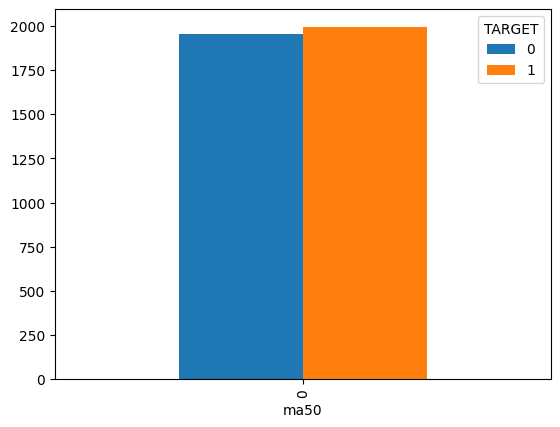

In [64]:
#sns.displot(x=new_df1["TARGET"],bins=3,kde=True)
#sns.boxplot(x=new_df1["yearly"])
#plt.pie(new_df1["ma20above100"].value_counts(),labels=new_df1["ma20above100"].value_counts().index)
#"yearly","weekly","ma20above50","ma50above100","ma20above100","ma5","ma20","ma50","ma100","ema5","ema10","ema20","ema50","ema100"
#sns.scatterplot(x=new_df1["weekly"],y=new_df1["TARGET"])
#sns.lmplot(data=new_df1,x="yearly",y="TARGET")
#sns.boxplot(x=new_df1["yearly"],y=new_df1["TARGET"])
ct = pd.crosstab(new_df1["ma50"],new_df1["TARGET"])
ct
ct.plot(kind="bar",stacked=False)